<img align="center" src="logos.png" width='1200px'>

# Bienvenidos &#x1F44B;

¡Script del grupo LOSA (29)! En este código se van a realizar los siguientes cálculos:
    
- Cálculo del area afectada por el íncendio a partir de imágenes Sentinel 2 y Landsat 8;
- Verificación del area quemada utilizado imágenes Fasat-Charlie;
- Creación de un mapa de la severidad del incendio en las areas quemadas;
- Creación de un índice para la prevención de incendios que tiene en cuenta la orografía, la humedad y la temperatura del suelo.

Es necesario tener agregada la libreria de Google Earth Engine, para hacerlo en una máquina virtual en jupyter se utilizan las siguientes lineas de código:

python -m venv ~/venvs/mi_ambiente

realpath /env/lib/python3.10/site-packages > ~/venvs/mi_ambiente/lib/python3.10/site-packages/base_venv.pth

source ~/venvs/mi_ambiente/bin/activate

pip3 install earthengine-api

python -m ipykernel install --user --name=mi_ambiente

>**Nota**: El nombre mi_ambiente puede ser cambiado por cualquier otro

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import rasterio
from rasterio.plot import show
from IPython.display import Image
import ee

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access
from datetime import date, timedelta, datetime

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, memory_limit='8GB')
client = Client(cluster)

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

from dea_tools.plotting import display_map, rgb

Se inicializa la cuenta de Google Earth Engine, es imprescindible tener un gmail para este paso y seguir los pasos que pide el autentificador

In [2]:
# Autenticación con Earth Engine
ee.Authenticate()
# Inicialización de Earth Engine
ee.Initialize()

Defino las coordenadas del area de estudio y un buffer y la fecha del incendio. 
En este caso las coordendas centradas en el incendio de Valparaiso, que son -33.1053, -71.4139 y el buffer seleccionado de 0.15.

La fecha del incendio es del 2-3 de febrero de 2024, hay dos variables que se tienen que inicializar, una es "fecha_anterior_pre" que debe de ser el día de antes del incendio y la otra es "fecha_poaterior_pre" que es el día posterior al incendio, una vez seleccionados estos días se busca en los tres meses anteriores al incendio y los tres meses posteriores. Este periodo se puede ampliar si en una primera búsqueda no se encuentra ninguna imagen disponible

In [3]:
buffer = 0.15;
lat = -33.1053;
lon = -71.4139;
fecha_anterior_pre = "2024-02-01";
fecha_posterior_pre = "2024-02-04";
fecha_convertida_anterior = date.fromisoformat(fecha_anterior_pre)
fecha_convertida_posterior = date.fromisoformat(fecha_posterior_pre)
nuevo_mes = fecha_convertida_anterior - timedelta(days=90) # Restar un mes completo (asumiendo 31 días)
fecha_anterior = nuevo_mes.strftime("%Y-%m-%d");
nuevo_mes = fecha_convertida_posterior + timedelta(days=90) # Restar un mes completo (asumiendo 31 días)
fecha_posterior = nuevo_mes.strftime("%Y-%m-%d");

Se define que satelite se quiere utilizar en la variable "satelite", las posibilidades son "s2_l2a" (Sentinel 2) o "landsat8_c2l2_sr" (Landsat 8), también podría ser cualquier otro satélite Landsat cambiado todos los "landsat8_c2l2_sr" por el identificador del otro Landsat, esta selección influirá en la resolución final de la imagen.

En cuanto al método de interpolación se puede seleccionar entre varios en la variable resampling_method ("nearest", "cubic", "bilinear"...), pero en nuestra experiencia el mejor método para ortorreferenciar imágenes con la menor pérdida de información es el "cubic".

In [4]:
satelite = "s2_l2a";

if satelite == "landsat8_c2l2_sr":
    resolution = 30;
    bandas_reflectancia = ["coastal", "blue", "green", "red", "nir08", "swir16", "swir22"]
elif satelite == "s2_l2a":
    resolution = 10;
    bandas_reflectancia = ["coastal", "blue", "green", "red", "nir", "nir08", "swir16", "swir22"]
    
resampling_method = "cubic";

query_anterior = {
    "product": satelite,
    "x": lon + np.array([buffer, -buffer]),
    "y": lat + np.array([buffer, -buffer]),
    "time": (fecha_anterior, fecha_anterior_pre),
    "output_crs": "EPSG:32719",
    "resolution": (-resolution, resolution),
    "resampling": resampling_method,
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

query_posterior = {
    "product": satelite,
    "x": lon + np.array([buffer, -buffer]),
    "y": lat + np.array([buffer, -buffer]),
    "time": (fecha_posterior_pre, fecha_posterior),
    "output_crs": "EPSG:32719",
    "resolution": (-resolution, resolution),
    "resampling": resampling_method,
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

Se visualiza el mapa de la zona seleccionada

In [5]:
display_map(x=query_anterior['x'], y=query_anterior['y'])

In [6]:
dc = datacube.Datacube(app='codigo')
d_anterior = dc.load(**query_anterior)
d_posterior = dc.load(**query_posterior)

Se obtiene la imagen de Fasat posterior al incendio

In [7]:
query_fasat = {
    "product": "fasat_charlie_ms",
    "x": lon + np.array([buffer, -buffer]),
    "y": lat + np.array([buffer, -buffer]),
    "time": ("2024-02-04", "2024-04-06"),
    "output_crs": "EPSG:32719",
    "resolution": (-5, 5),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}
ds_fasat = dc.load(**query_fasat)
ds_fasat.update(ds_fasat * 0.0001)

<xarray.Dataset>
Dimensions:      (time: 1, y: 6784, x: 5754)
Coordinates:
  * time         (time) datetime64[ns] 2024-02-09T14:06:30.238724
  * y            (y) float64 6.351e+06 6.351e+06 ... 6.317e+06 6.317e+06
  * x            (x) float64 2.603e+05 2.603e+05 ... 2.891e+05 2.891e+05
    spatial_ref  int32 32719
Data variables:
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Visualizamos un falso RGB (nir-Red-Green) para realzar las zonas post incendio

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


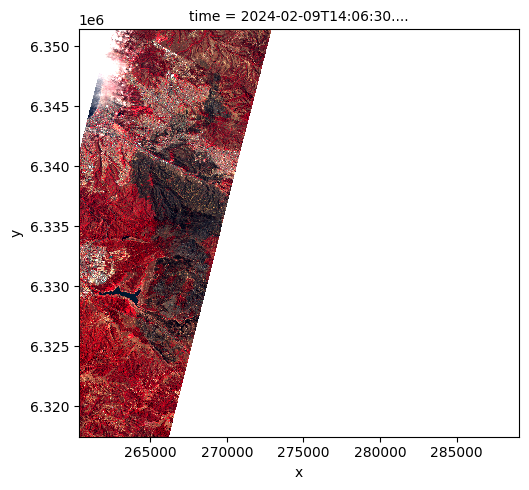

In [8]:
ds_fasat = ds_fasat.where(ds_fasat != 0, np.nan)
ds_fasat[["nir", "red", "green"]].to_array().plot.imshow(col = "time", col_wrap = 2, robust=True, figsize=(10, 5))

Pasamos ahora a realizar una clasificiación no supervisada con k-means donde una de las clases se corresponderá con el área quemada

In [9]:
imagen_fasat = ds_fasat.isel(time = 0)
imagen_fasat_stack = np.stack((imagen_fasat['blue'].values, imagen_fasat['green'].values, imagen_fasat['red'].values,imagen_fasat['nir'].values), axis=-1)
n_filas, n_columnas, n_bandas = imagen_fasat_stack.shape
fasat_2d = np.reshape(imagen_fasat_stack, (n_filas * n_columnas, n_bandas))

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [10]:
#Pasamos la imagen a formato matriz, primera dimensión píxeles y segunda dimensión bandas, y generamos una mascara de NaNs
mascara_noNaN = ~np.isnan(fasat_2d).any(axis=1)
indices_no_nan = np.argwhere(mascara_noNaN)
fasat_2d_noNaN = fasat_2d[mascara_noNaN]

In [11]:
#Separamos el clasificador en una celda propia ya que el entrenamiento puede requerir tiempo
from sklearn.cluster import KMeans

num_clusters = 6  # Número de clases
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(fasat_2d_noNaN)

/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

Finalmente clasificamos los píxeles y mostramos el mapa de clases

Text(0.5, 1.0, 'Clasificación por K-Means')

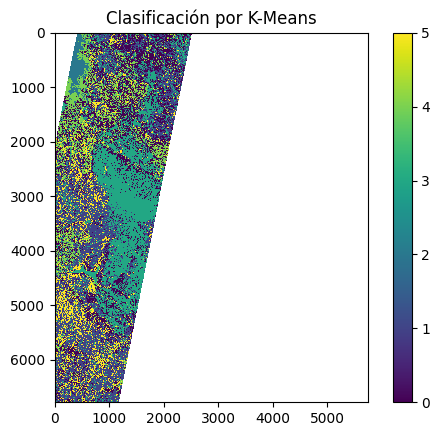

In [12]:
etiquetas = kmeans.predict(fasat_2d_noNaN)

matriz_nan = np.full((fasat_2d.shape[0]), np.nan)
matriz_nan[indices_no_nan[:, 0]] = etiquetas
fasat_clas = np.reshape(matriz_nan,(n_filas,n_columnas))

plt.imshow(fasat_clas, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Clasificación por K-Means')

La clase 3 corresponde a las áreas quemadas

Dentro de las imágenes seleccionadas de Landsat o Sentinel se descartan aquellas que superen el umbral definido de porcentaje de nubes. En este caso se define que solo se conservaran aquellas imágenes en las que el 90-100% o mas de la imágen no sean nubes/nieve/cirrus/sombras, pero esto se puede cambiar el la variable "valid_threshold".

In [13]:
if satelite == "landsat8_c2l2_sr":
    good_pixel_flags = {
        "snow": "not_high_confidence",
        "cloud": "not_high_confidence",
        "cirrus": "not_high_confidence",
        "cloud_shadow": "not_high_confidence",
        "nodata": False
    }

    quality_band = 'qa_pixel'
    valid_threshold = 0.95

    cloud_free_mask1 = masking.make_mask(d_anterior[quality_band], **good_pixel_flags)
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_anterior = d_anterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_anterior = dsf_anterior.sel(time=observations_to_keep).persist()

    cloud_free_mask1 = masking.make_mask(d_posterior[quality_band], **good_pixel_flags)
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_posterior = d_posterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_posterior = dsf_posterior.sel(time=observations_to_keep).persist()
elif satelite == "s2_l2a":
    valid_threshold = 0.97
    cloud_free_mask1 = (
    masking.make_mask(d_anterior.scl, qa="vegetation") | 
    masking.make_mask(d_anterior.scl, qa="bare soils") | 
    masking.make_mask(d_anterior.scl, qa="unclassified") 
    )
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_anterior = d_anterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_anterior = dsf_anterior.sel(time=observations_to_keep).persist()
    
    cloud_free_mask1 = (
    masking.make_mask(d_posterior.scl, qa="vegetation") | 
    masking.make_mask(d_posterior.scl, qa="bare soils") |
    masking.make_mask(d_posterior.scl, qa="dark area pixels") | #se añade este tipo de pixeles porque después del incendio hay muchos pixeles de este tipo
    masking.make_mask(d_posterior.scl, qa="unclassified")
    )
    
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_posterior = d_posterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_posterior = dsf_posterior.sel(time=observations_to_keep).persist()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Se observa si tras el filtrado se han encontrado imágenes anteriores al incendio, en el caso de que este vacio, se debería ampliar el periodo de búsqueda de imágenes definido al principio como 3 meses

In [14]:
ds_keep_anterior

<xarray.Dataset>
Dimensions:      (time: 6, y: 3393, x: 2878)
Coordinates:
  * time         (time) datetime64[ns] 2023-11-19T14:52:05.186000 ... 2024-01...
  * y            (y) float64 6.351e+06 6.351e+06 ... 6.317e+06 6.317e+06
  * x            (x) float64 2.603e+05 2.603e+05 ... 2.891e+05 2.891e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir08        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Se observa si tras el filtrado se han encontrado imágenes posterioes al incendio, en el caso de que este vacio, se debería ampliar el periodo de búsqueda de imágenes definido al principio como 3 meses

In [15]:
ds_keep_posterior

<xarray.Dataset>
Dimensions:      (time: 6, y: 3393, x: 2878)
Coordinates:
  * time         (time) datetime64[ns] 2024-02-12T14:52:04.975000 ... 2024-03...
  * y            (y) float64 6.351e+06 6.351e+06 ... 6.317e+06 6.317e+06
  * x            (x) float64 2.603e+05 2.603e+05 ... 2.891e+05 2.891e+05
    spatial_ref  int32 32719
Data variables:
    coastal      (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir08        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

Se pasan los valores a reflectancias

In [16]:
if satelite == "landsat8_c2l2_sr":
  ds_keep_anterior.update(ds_keep_anterior * 0.0000275 + -0.2);
  ds_keep_anterior.update(ds_keep_anterior.where(ds_keep_anterior >= 0).where(ds_keep_anterior <= 1));
  ds_keep_posterior.update(ds_keep_posterior * 0.0000275 + -0.2);
  ds_keep_posterior.update(ds_keep_posterior.where(ds_keep_posterior >= 0).where(ds_keep_posterior <= 1));
elif satelite== "s2_l2a":
  ds_keep_anterior.update(ds_keep_anterior * 0.0001);
  ds_keep_anterior.update(ds_keep_anterior.where(ds_keep_anterior >= 0).where(ds_keep_anterior <= 1));
  ds_keep_posterior.update(ds_keep_posterior * 0.0001);
  ds_keep_posterior.update(ds_keep_posterior.where(ds_keep_posterior >= 0).where(ds_keep_posterior <= 1));

Se muestra los RGBs de la colección de imágene extraídas anteriores al incendio

In [ ]:
ds_keep_anterior[["red", "green", "blue"]].to_array().plot.imshow(col = "time", col_wrap = 2, robust=True, figsize=(15, 20))

/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


Se muestra los RGBs de la colección de imágenes extraídas posteriores al incendio

In [ ]:
ds_keep_posterior[["red", "green", "blue"]].to_array().plot.imshow(col = "time", col_wrap = 2, robust=True, figsize=(15, 20))

Se elige que índice de vegetación se quiere utilizar en la variable "indice_veg", las posibilidades son NDVI, KNDVI, EVI, NDWI (o índice de area quemada (NBR)) 

In [ ]:
ultimo_indice = len(ds_keep_anterior["time"]) - 1
imagen_anterior = ds_keep_anterior.isel(time = ultimo_indice)
imagen_posterior = ds_keep_posterior.isel(time = 0)

In [ ]:
indice_veg = "NDVI";

In [ ]:
if satelite == "landsat8_c2l2_sr":
    if indice_veg == "NDVI":
      indice_anterior = (imagen_anterior['nir08'] - imagen_anterior['red']) / (imagen_anterior['nir08'] + imagen_anterior['red'])
      indice_posterior = (imagen_posterior['nir08'] - imagen_posterior['red']) / (imagen_posterior['nir08'] + imagen_posterior['red'])
    elif indice_veg == "KNDVI" :
      ndvi = (imagen_anterior['nir08'] - imagen_anterior['red']) / (imagen_anterior['nir08'] + imagen_anterior['red'])
      ndvi2 = ndvi ** 2
      indice_anterior = np.tanh(ndvi2)
      ndvi = (imagen_posterior['nir08'] - imagen_posterior['red']) / (imagen_posterior['nir08'] + imagen_posterior['red'])
      ndvi2 = ndvi ** 2
      indice_posterior = np.tanh(ndvi2)
    elif indive_veg == "EVI" :
      indice_anterior = 2.5 * ((imagen_anterior['nir08'] - imagen_anterior['red']) / (imagen_anterior['nir08'] + 6 * imagen_anterior['red'] - 7.5 * imagen_anterior['blue'] + 1))
      indice_posterior = 2.5 * ((imagen_posterior['nir08'] - imagen_posterior['red']) / (imagen_posterior['nir08'] + 6 * imagen_posterior['red'] - 7.5 * imagen_posterior['blue'] + 1))
    elif indice_veg == "NDWI" :
      indice_anterior = (imagen_anterior['nir08'] - imagen_anterior['swir16']) / (imagen_anterior['nir08'] + imagen_anterior['swir16'])
      indice_posterior = (imagen_posterior['nir08'] - imagen_posterior['swir16']) / (imagen_posterior['nir08'] + imagen_posterior['swir16'])
elif satelite == "s2_l2a":
    if indice_veg == "NDVI":
      indice_anterior = (imagen_anterior['nir'] - imagen_anterior['red']) / (imagen_anterior['nir'] + imagen_anterior['red'])
      indice_posterior = (imagen_posterior['nir'] - imagen_posterior['red']) / (imagen_posterior['nir'] + imagen_posterior['red'])
    elif indice_veg == "KNDVI" :
      ndvi = (imagen_anterior['nir'] - imagen_anterior['red']) / (imagen_anterior['nir'] + imagen_anterior['red'])
      ndvi2 = ndvi ** 2
      indice_anterior = np.tanh(ndvi2)
      ndvi = (imagen_posterior['nir'] - imagen_posterior['red']) / (imagen_posterior['nir'] + imagen_posterior['red'])
      ndvi2 = ndvi ** 2
      indice_posterior = np.tanh(ndvi2)
    elif indive_veg == "EVI" :
      indice_anterior = 2.5 * ((imagen_anterior['nir'] - imagen_anterior['red']) / (imagen_anterior['nir'] + 6 * imagen_anterior['red'] - 7.5 * imagen_anterior['blue'] + 1))
      indice_posterior = 2.5 * ((imagen_posterior['nir'] - imagen_posterior['red']) / (imagen_posterior['nir'] + 6 * imagen_posterior['red'] - 7.5 * imagen_posterior['blue'] + 1))
    elif indice_veg == "NDWI" :
      indice_anterior = (imagen_anterior['nir'] - imagen_anterior['swir16']) / (imagen_anterior['nir'] + imagen_anterior['swir16'])
      indice_posterior = (imagen_posterior['nir'] - imagen_posterior['swir16']) / (imagen_posterior['nir'] + imagen_posterior['swir16'])

Imagen del índice seleccionado el día anterior mas próximo al íncendio

In [ ]:
indice_anterior
fig, ax = plt.subplots(1, 1)
indice_anterior.plot(robust=True)
ax.set_facecolor("black")

Imagen del índice seleccionado el día posterior mas próximo al íncendio

In [ ]:
indice_posterior
fig, ax = plt.subplots(1, 1)
indice_posterior.plot(robust=True)
ax.set_facecolor("black")

Diferencia del índice seleccionado entre el día mas próximo al incendio tanto anterior como posterior. En esta imagen debe de quedar resaltada el area del incendio

In [ ]:
dif_indice = indice_anterior - indice_posterior
dif_indice
fig, ax = plt.subplots(1, 1)
dif_indice.plot(robust=True)
ax.set_facecolor("black")

Se crea una máscara inicial del incendio

In [ ]:
lim = 0.1
mask = dif_indice > lim
fig, ax = plt.subplots(1, 1)
plt.imshow(mask, cmap='gray')
plt.show()

Se realizan una serie de operaciones morfológicas para refinar la máscara del incendio, teniendo en cuenta con que resolución espacial se trabaja dependiendo del satélite utilizado

In [ ]:
from scipy import ndimage
import numpy as np

# Definir el kernel para la operación de erosión
m_kernel = 100
redondeado = math.ceil(m_kernel/resolution)
if redondeado % 2 == 0:
    redondeado += 1
structure = np.ones((redondeado, redondeado))

mask = ndimage.binary_dilation(mask, structure=structure).astype(mask.dtype)
# Aplicar la operación de erosión
mask_eroded = ndimage.binary_erosion(mask, structure=structure).astype(mask.dtype)
mask_eroded = ndimage.binary_erosion(mask_eroded, structure=structure).astype(mask.dtype)
mask_eroded = ndimage.binary_erosion(mask_eroded, structure=structure).astype(mask.dtype)
mask_eroded = ndimage.binary_erosion(mask_eroded, structure=structure).astype(mask.dtype)
mask_dilated = ndimage.binary_dilation(mask_eroded, structure=structure).astype(mask.dtype)
mask_dilated = ndimage.binary_dilation(mask_dilated, structure=structure).astype(mask.dtype)
mask_dilated = ndimage.binary_dilation(mask_dilated, structure=structure).astype(mask.dtype)
plt.imshow(mask_dilated, cmap='gray')
plt.show()

Se cuenta el número de pixeles de la máscara y se da el resultado del area quemada

In [ ]:
num_pixels = np.count_nonzero(mask_dilated)

area = num_pixels*resolution*resolution/1000000

print(f"Se han quemado un total de: {area} Km^2 = {area*100} ha")

Se utiliza la máscara hecha a partir del algoritmo k-means con la imagen de FASAT para validar los cálculos anteriores del area quemada con los satelites Landsat o Sentinel.
En este parte se tiene en cuenta que la imagen de Fasat no cubre todo el incendio, entonces se recorta las otras imágenes de satélite para que sean comparables con la imagen de Fasat para poder realizar la validación.

In [ ]:
from skimage.transform import resize
dif_indice_resize = resize(dif_indice, (fasat_clas.shape[0], fasat_clas.shape[1]), order=1, mode='constant', anti_aliasing=True)
lim = 0.1
mask_resize = dif_indice_resize > lim

from scipy import ndimage
import numpy as np

# Definir el kernel para la operación de erosión
m_kernel = 100
resolution = 5
redondeado = math.ceil(m_kernel/resolution)
if redondeado % 2 == 0:
    redondeado += 1
structure = np.ones((redondeado, redondeado))

if satelite == "landsat8_c2l2_sr":
    resolution = 30
elif satelite == "s2_l2a":
    resolution = 10

mask = ndimage.binary_dilation(mask_resize, structure=structure).astype(mask.dtype)
# Aplicar la operación de erosión
mask_eroded = ndimage.binary_erosion(mask, structure=structure).astype(mask.dtype)
mask_eroded = ndimage.binary_erosion(mask_eroded, structure=structure).astype(mask.dtype)
mask_eroded = ndimage.binary_erosion(mask_eroded, structure=structure).astype(mask.dtype)
mask_eroded = ndimage.binary_erosion(mask_eroded, structure=structure).astype(mask.dtype)

mask_dilated2 = ndimage.binary_dilation(mask_eroded, structure=structure).astype(mask.dtype)
mask_dilated2 = ndimage.binary_dilation(mask_dilated2, structure=structure).astype(mask.dtype)
mask_dilated2 = ndimage.binary_dilation(mask_dilated2, structure=structure).astype(mask.dtype)

resultado = mask_dilated2 * fasat_clas
plt.imshow(resultado, cmap='viridis')

numero_clase_3 = np.count_nonzero(etiquetas == 3)*5*5/1000000
numero_quemados = np.count_nonzero(resultado > 0)*5*5/1000000
print(f"El área quemada (Clase 3) en la imagen de Fasat-Charlie es de: {numero_clase_3} Km^2")
print("El área quemada para " + satelite + f" es de: {numero_quemados} Km^2")

## 2ª Parte

La finalidad de esta parte es crear un mapa que evalue como ha afectado el incendio a las distintas zonas, si se ha perdido toda la vegetación o solo una parte de ella. Este cálculo se realiza mediante el KNDVI, que es un proxy del LAI, que mide linealmente la cantidad de vegetación presente en cada pixel, por lo que si se detecta una bajada abrupta del KNDVI antes (https://www.science.org/doi/10.1126/sciadv.abc7447)

In [ ]:
#En fecha se específica el periodo con el periodo que se quiere comparar

#Definir el año y el mes
año = 2024
mes = 3

# Crear una nueva fecha con el año 2023 y el mismo mes
if mes == 2:
  fecha_anterior_pre = datetime(2023, mes, 1)
  fecha_anterior_post = datetime(2023, mes, 28)
  fecha_posterior_pre = datetime(año, mes, 1)
  fecha_posterior_post = datetime(año, mes, 28)
elif mes == 1 or mes == 3 or mes == 5 or mes == 7 or mes == 8 or mes == 10 or mes == 12:
  fecha_anterior_pre = datetime(2023, mes, 1)
  fecha_anterior_post = datetime(2023, mes, 31)
  fecha_posterior_pre = datetime(año, mes, 1)
  fecha_posterior_post = datetime(año, mes, 31)
else:
  fecha_anterior_pre = datetime(2023, mes, 1)
  fecha_anterior_post = datetime(2023, mes, 30)
  fecha_posterior_pre = datetime(año, mes, 1)
  fecha_posterior_post = datetime(año, mes, 30)

In [ ]:
##Toda esta celda es una réplica de la primera parte para filtrar nubes y escalar a reflectancias
query_anterior = {
    "product": satelite,
    "x": lon + np.array([buffer, -buffer]),
    "y": lat + np.array([buffer, -buffer]),
    "time": (fecha_anterior_pre,fecha_anterior_post),
    "output_crs": "EPSG:32719",
    "resolution": (-resolution, resolution),
    "resampling": resampling_method,
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

query_posterior = {
    "product": satelite,
    "x": lon + np.array([buffer, -buffer]),
    "y": lat + np.array([buffer, -buffer]),
    "time":  (fecha_posterior_pre,fecha_posterior_post),
    "output_crs": "EPSG:32719",
    "resolution": (-resolution, resolution),
    "resampling": resampling_method,
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

dc = datacube.Datacube(app='codigo')
d_anterior = dc.load(**query_anterior)
d_posterior = dc.load(**query_posterior)

if satelite == "landsat8_c2l2_sr":
    good_pixel_flags = {
        "snow": "not_high_confidence",
        "cloud": "not_high_confidence",
        "cirrus": "not_high_confidence",
        "cloud_shadow": "not_high_confidence",
        "nodata": False
    }

    quality_band = 'qa_pixel'
    valid_threshold = 0.95

    cloud_free_mask1 = masking.make_mask(d_anterior[quality_band], **good_pixel_flags)
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_anterior = d_anterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_anterior = dsf_anterior.sel(time=observations_to_keep).persist()

    cloud_free_mask1 = masking.make_mask(d_posterior[quality_band], **good_pixel_flags)
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_posterior = d_posterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_posterior = dsf_posterior.sel(time=observations_to_keep).persist()
elif satelite == "s2_l2a":
    valid_threshold = 0.95
    cloud_free_mask1 = (
    masking.make_mask(d_anterior.scl, qa="vegetation") | 
    masking.make_mask(d_anterior.scl, qa="bare soils") | 
    masking.make_mask(d_anterior.scl, qa="unclassified") 
    )
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_anterior = d_anterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_anterior = dsf_anterior.sel(time=observations_to_keep).persist()
    
    cloud_free_mask1 = (
    masking.make_mask(d_posterior.scl, qa="vegetation") | 
    masking.make_mask(d_posterior.scl, qa="bare soils") | 
    masking.make_mask(d_posterior.scl, qa="unclassified")
    )
    
    valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2]);
    observations_to_keep = (valid_pixel_proportion >= valid_threshold)
    dsf_posterior = d_posterior[bandas_reflectancia].where(cloud_free_mask1)
    ds_keep_posterior = dsf_posterior.sel(time=observations_to_keep).persist()
    
if satelite == "landsat8_c2l2_sr":
  ds_keep_anterior.update(ds_keep_anterior * 0.0000275 + -0.2);
  ds_keep_anterior.update(ds_keep_anterior.where(ds_keep_anterior >= 0).where(ds_keep_anterior <= 1));
  ds_keep_posterior.update(ds_keep_posterior * 0.0000275 + -0.2);
  ds_keep_posterior.update(ds_keep_posterior.where(ds_keep_posterior >= 0).where(ds_keep_posterior <= 1));
elif satelite== "s2_l2a":
  ds_keep_anterior.update(ds_keep_anterior * 0.0001);
  ds_keep_anterior.update(ds_keep_anterior.where(ds_keep_anterior >= 0).where(ds_keep_anterior <= 1));
  ds_keep_posterior.update(ds_keep_posterior * 0.0001);
  ds_keep_posterior.update(ds_keep_posterior.where(ds_keep_posterior >= 0).where(ds_keep_posterior <= 1));
   
    
ultimo_indice = len(ds_keep_anterior["time"]) - 1
imagen_anterior = ds_keep_anterior.isel(time = ultimo_indice)
imagen_posterior = ds_keep_posterior.isel(time = 0)

In [ ]:
#En esta celda calculamos el kNDVI como proxy de la biomasa perdida
if satelite == "landsat8_c2l2_sr":
  ndvi = (imagen_anterior['nir08'] - imagen_anterior['red']) / (imagen_anterior['nir08'] + imagen_anterior['red'])
  ndvi2 = ndvi ** 2
  indice_anterior = np.tanh(ndvi2)
  ndvi = (imagen_posterior['nir08'] - imagen_posterior['red']) / (imagen_posterior['nir08'] + imagen_posterior['red'])
  ndvi2 = ndvi ** 2
  indice_posterior = np.tanh(ndvi2)
elif satelite == "s2_l2a":
  ndvi = (imagen_anterior['nir'] - imagen_anterior['red']) / (imagen_anterior['nir'] + imagen_anterior['red'])
  ndvi2 = ndvi ** 2
  indice_anterior = np.tanh(ndvi2)
  ndvi = (imagen_posterior['nir'] - imagen_posterior['red']) / (imagen_posterior['nir'] + imagen_posterior['red'])
  ndvi2 = ndvi ** 2
  indice_posterior = np.tanh(ndvi2)

In [ ]:
perdida = (indice_anterior - indice_posterior)*mask_dilated/(indice_anterior) 
#perdida = (indice_anterior - indice_posterior)

fig, ax = plt.subplots(1, 1)
perdida.plot(robust=True)
ax.set_facecolor("black")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

vmin, vmax = 0.3, 1

fig, ax = plt.subplots()
im = ax.imshow(perdida, cmap='YlOrRd', vmin=vmin, vmax=vmax, aspect='auto')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Severidad')
cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cbar.set_ticklabels(['Baja', 'Media', 'Alta'])
ax.set_title('Mapa de perdida')
ax.set_facecolor("black")
plt.show()

In [ ]:
mask_high = perdida > 0.6
mask_mid = (perdida > 0.4) & (perdida < 0.6)
mask_low = (perdida > 0.2) & (perdida < 0.4)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(mask_high, cmap='gray')
axs[0].set_title('Pérdida > 60%')
axs[0].axis('off')

axs[1].imshow(mask_mid, cmap='gray')
axs[1].set_title('Pérdida entre el 40% y el 60%')
axs[1].axis('off')

axs[2].imshow(mask_low, cmap='gray')
axs[2].set_title('Pérdida entre el 20% y el 40%')
axs[2].axis('off')

plt.show()

In [35]:
# Genera un histograma de la imagen
hist, bin_edges = np.histogram(perdida, bins=[0, 0.2, 0.4, 0.6, 1.0])
count_0_0_2 = hist[0]*resolution*resolution/1000000
count_0_2_0_4 = hist[1]*resolution*resolution/1000000
count_0_4_0_6 = hist[2]*resolution*resolution/1000000
count_0_6_1_0 = hist[3]*resolution*resolution/1000000

print(f"Pérdidas entre 20% y 40% de vegetación: {count_0_2_0_4} Km^2 = {count_0_2_0_4*100} ha")
print(f"Pérdidas entre 40% y 60% de vegetación: {count_0_4_0_6} Km^2 = {count_0_4_0_6*100} ha")
print(f"Pérdidas entre 60% y 100% de vegetación: {count_0_6_1_0} Km^2 = {count_0_6_1_0*100} ha")

Pérdidas entre 20% y 40% de vegetación: 8.2305 Km^2 = 823.05 ha
Pérdidas entre 40% y 60% de vegetación: 13.9689 Km^2 = 1396.8899999999999 ha
Pérdidas entre 60% y 100% de vegetación: 61.4619 Km^2 = 6146.19 ha


## 3ª Parte

En esta sección podemos elegir cualquier coordenada para obtener un mapa de riesgo de incendio. Para ello seleccionaremos la latitud y longitud y el buffer para defir el lugar y el tamaño del mapa. Para obtener el índice de riesgo hacemos uso de la colección SMAP de la NASA. Esta colección cambia de nombre en función de la fecha que elijamos, por esta razón, si seleccionamos una fecha anterior a 4/12/2023 deberemos usar coleccion_smap = 'NASA/SMAP/SPL3SMP_E/005', mientras que si consultamos una fecha posterior haremos uso de coleccion_smap = 'NASA/SMAP/SPL3SMP_E/006'.

In [36]:
# Definir la geometría de recorte
buffer = 0.15;
lat = -33.1053;
lon = -71.4139;
geometry = ee.Geometry.Polygon([
    [lon - buffer, lat - buffer],
    [lon - buffer, lat + buffer],
    [lon + buffer, lat - buffer],
    [lon + buffer, lat + buffer]
])
resolution = 30;

# Definir la fecha de interés

# Día antes del incendio
startDateRiesgo = '2023-12-01'
endDateRiesgo = '2024-02-01'
coleccion_smap = 'NASA/SMAP/SPL3SMP_E/006'

# Invierno
#startDateRiesgo = '2023-4-01'
#endDateRiesgo = '2023-6-01'
#coleccion_smap = 'NASA/SMAP/SPL3SMP_E/005'

In [37]:
# Temperatura
# Cargar la colección VIIRS
collection = ee.ImageCollection('NOAA/VIIRS/001/VNP21A1D') \
    .filterDate(startDateRiesgo,endDateRiesgo) \
    .filterBounds(geometry) \
    .sort('system:time_start', False)  # Ordenar la colección en orden descendente por fecha

# Seleccionar la primera imagen de la colección
image = collection.first()

# Aplicar las operaciones matemáticas
result = image.select('LST_1KM').subtract(273)
# Reproyectar la imagen a EPSG:32719 y elegir la resolución
T = result.reproject(crs='EPSG:32719', scale=resolution)
# Mostrar la imagen resultante
Image(url=T.getThumbUrl({
    'min': 0,
    'max': 60,
    'region': geometry,
    'dimensions': 512,
    'format': 'jpg'
}))

In [38]:
# Humedad
# Cargar la colección NASA SMAP Soil Moisture
collection_smap = ee.ImageCollection(coleccion_smap) \
    .filterDate(startDateRiesgo,endDateRiesgo) \
    .filterBounds(geometry) \
    .sort('system:time_start', False)  # Ordenar la colección en orden descendente por fecha

# Seleccionar la primera imagen de la colección NASA SMAP Soil Moisture
image_smap = collection_smap.first()

# Aplicar las operaciones matemáticas para NASA SMAP Soil Moisture
result_smap = image_smap.select('soil_moisture_am')
hum = result_smap.reproject(crs='EPSG:32719', scale=resolution)
# Mostrar la imagen resultante de NASA SMAP Soil Moisture
Image(url=hum.getThumbUrl({
    'min': 0,
    'max': 0.3,
    'region': geometry,
    'dimensions': 512,
    'format': 'jpg'
}))

In [39]:
# DEM

query_dem = {
    "product": 'copernicus_dem_30',
    "x": lon + np.array([buffer, -buffer]),
    "y": lat + np.array([buffer, -buffer]),
    "output_crs": "EPSG:32719",
    "resolution": (-resolution, resolution),
    "resampling": resampling_method,
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

dem = dc.load(**query_dem)

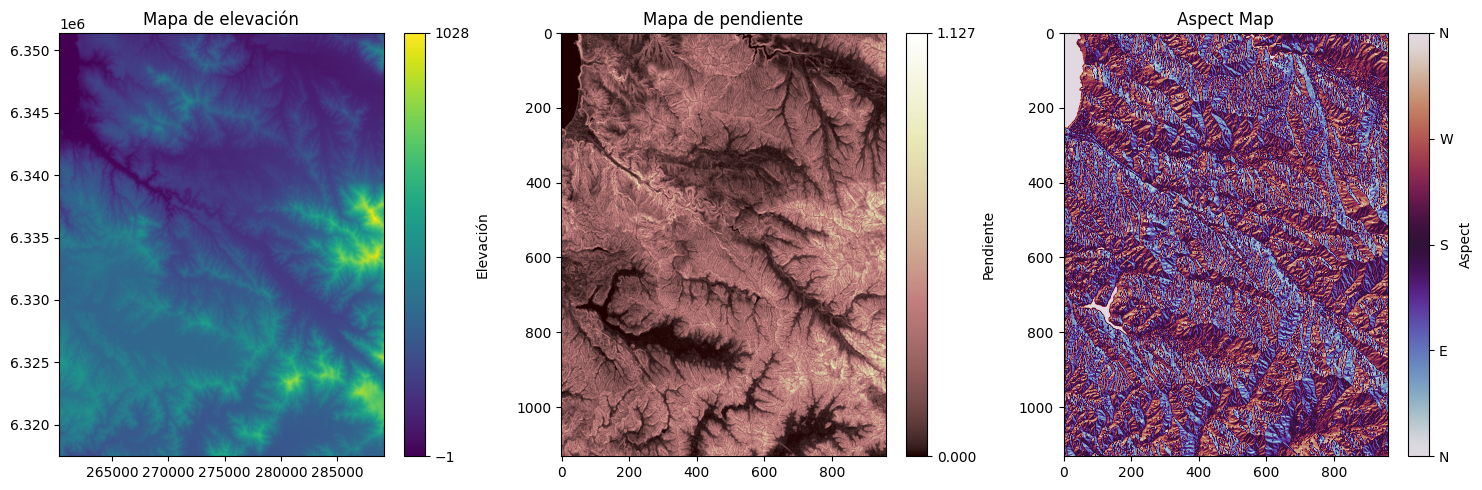

In [40]:
# Mapas obtenidos a partir del DEM

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Calcula la elevación
elevation = dem['elevation']
elevation_values = elevation.values
x = elevation['x'].values
y = elevation['y'].values

# Calcula la pendiente
elevation = dem['elevation'].values[0, :, :]
dz_dx, dz_dy = np.gradient(elevation, resolution, resolution)
slope = np.sqrt(dz_dx**2 + dz_dy**2)

# Calcula el ángulo de la pendiente (aspect)
aspect = 180.0 + np.arctan2(dz_dy, -dz_dx) * (180.0 / np.pi)
aspect[aspect < 0] += 360.0  # Convierte los ángulos negativos a positivos

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Dibuja el mapa de elevación
im = axs[0].imshow(elevation_values[0, :, :], cmap='viridis', aspect='auto', extent=[x.min(), x.max(), y.min(), y.max()])
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('Elevación')
cbar.set_ticks([elevation_values.min(), elevation_values.max()])
axs[0].set_title('Mapa de elevación')
axs[0].set_facecolor("black")

# Dibuja el mapa de pendiente
im1 = axs[1].imshow(slope, cmap='pink', aspect='auto')
cbar1 = fig.colorbar(im1, ax=axs[1])
cbar1.set_label('Pendiente')
cbar1.set_ticks([slope.min(), slope.max()])
axs[1].set_title('Mapa de pendiente')
axs[1].set_facecolor("black")

# Dibuja el mapa de aspecto
im2 = axs[2].imshow(aspect, cmap='twilight', aspect='auto', vmin=0, vmax=360)
cbar2 = fig.colorbar(im2, ax=axs[2])
cbar2.set_label('Aspect')
cbar2.set_ticks([0, 90, 180, 270, 360])
cbar2.set_ticklabels(['N', 'E', 'S', 'W', 'N'])
axs[2].set_title('Aspect Map')
axs[2].set_facecolor("black")

# Muestra la figura

plt.tight_layout()
plt.show()

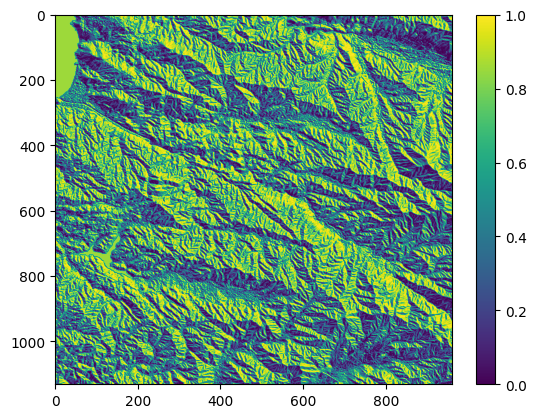

In [41]:
# Orientación NE más probabilidad de estado seco de la vegetación

orientacionNE = (np.cos(np.radians(aspect-45))+1)/2
fig, ax = plt.subplots()
im = ax.imshow(orientacionNE, aspect='auto')
cbar = fig.colorbar(im, ax=ax)
ax.set_facecolor("black")
plt.show()

Para calcular la posibilidad de incendio aplicamos el siguiente indice, que tiene en consideración la temperatura, la humedad y la orientación del terreno. Se ha considerado valores menores de 20ºC de LST como indice 0 y valores superiores a 60ºC como indice 1. Para la humedad, se considera el 0% de humedad como indicce 1 y el 100% de humedad como indice 0. Para la orientación se considera que las pendientes orientación NE son las más secas y por tanto más propensas a quemarse. H = (T-20)/(60-20) + (1-hum) + orientacionNE)/3

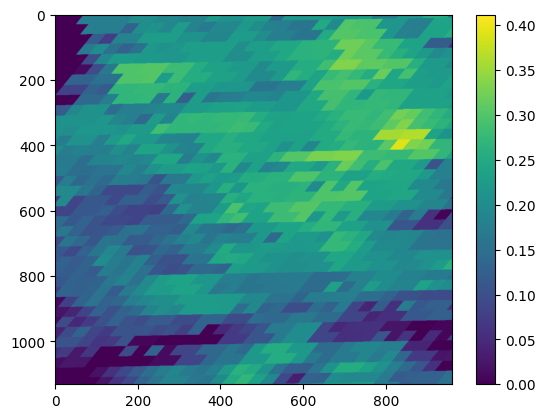

In [42]:
# Indice de temperatura

url_in = T.getThumbUrl({
    'min': 20,
    'max': 50,
    'region': geometry,
    'dimensions': (960,1132),
    'format': 'jpg'
})

# Descargar la imagen como una matriz numpy
import requests
from PIL import Image
from io import BytesIO

response = requests.get(url_in)
img = Image.open(BytesIO(response.content))
T_in = np.array(img)/255
fig, ax = plt.subplots()
im = ax.imshow(T_in, aspect='auto')
cbar = fig.colorbar(im, ax=ax)
ax.set_facecolor("black")
plt.show()

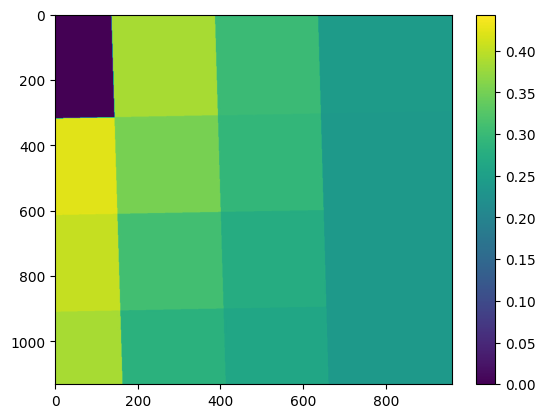

In [43]:
#Indice de Humedad

url_in = hum.getThumbUrl({
    'min': 0,
    'max': 1,
    'region': geometry,
    'dimensions': (960,1132),
    'format': 'jpg'
})

# Descargar la imagen como una matriz numpy
import requests
from PIL import Image
from io import BytesIO

response = requests.get(url_in)
img = Image.open(BytesIO(response.content))
hum_in = np.array(img)/255
fig, ax = plt.subplots()
im = ax.imshow(hum_in, aspect='auto')
cbar = fig.colorbar(im, ax=ax)
ax.set_facecolor("black")
plt.show()

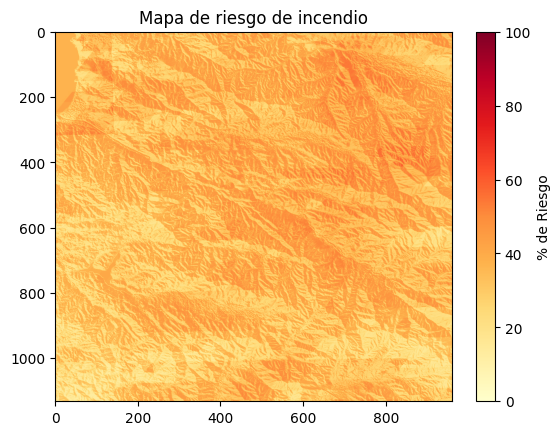

In [44]:
# Mapa de riesgo de incendio

H = (0.6*T_in + 0.2*(1-hum_in) + 0.2*orientacionNE)*100
fig, ax = plt.subplots()
im = ax.imshow(H, cmap='YlOrRd', vmin=0, vmax=100, aspect='auto')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% de Riesgo')
ax.set_title('Mapa de riesgo de incendio')
ax.set_facecolor("black")
plt.show()